In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.models as models
import torch
from MTL.model import resnet,MTL_model,mobilenet
import torch.nn as nn
from utils.train_utils import *
from data.datasets import FERDataset
from torch.utils.data import DataLoader
import time

label={'sad':0, 'happy':1, 'angry':2, 'disgust':3, 'surprise':4, 'fear':5, 'neutral':6}
labels= {v: k for k, v in label.items()}
gender={0:'man',1:'woman'}
device='cuda:0'

# Fer2013 data에 성능 비교

# Single models

test accuracy: 67.94, inference time:4.251753091812134
train accuracy: 72.56, inference time:26.486189365386963


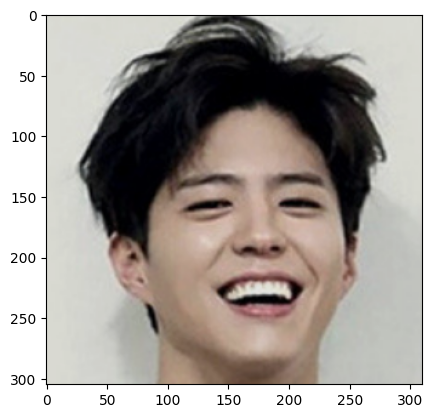

happy
man


In [6]:

emotion_model=resnet.EmotionModel(phase='test')

state_dict=torch.load('weight/classification/Exp_128_resnet_best.pt')
emotion_model.load_state_dict(state_dict)
emotion_model.to(device)

gender_model=resnet.GenderModel(phase='test')

g_state_dict=torch.load('weight/classification/gender_128_resnet_best.pt')
gender_model.load_state_dict(g_state_dict)
gender_model.to(device)

emotion_model.eval()
gender_model.eval()

test_ds=FERDataset('test')
test_dl=DataLoader(test_ds,batch_size=32,shuffle=True,num_workers=1)
corrects=0
start=time.time()

for img,label in test_dl:
    img=img.to(device)
    label=label.to(device)
    
    output=emotion_model(img)
    emotion_output=output
    
    pred=emotion_output.argmax(1,keepdim=True)
    corrects+=pred.eq(label.view_as(pred)).sum().item()
    output1=gender_model(img) # gender는 일단 이 test에서는 필요 없지만 추론속도에는 포함시킴
end=time.time()
  
accuracy=corrects/len(test_dl.dataset)
print(f'test accuracy: {accuracy*100:.2f}, inference time:{end-start}')

test_ds=FERDataset('train')
test_dl=DataLoader(test_ds,batch_size=32,shuffle=True,num_workers=1)
corrects=0
start=time.time()
for img,label in test_dl:
    img=img.to(device)
    label=label.to(device)
    
    output=emotion_model(img)
    emotion_output=output
    
    pred=emotion_output.argmax(1,keepdim=True)
    corrects+=pred.eq(label.view_as(pred)).sum().item()
    output1=gender_model(img)
end=time.time()   

accuracy=corrects/len(test_dl.dataset)
print(f'train accuracy: {accuracy*100:.2f}, inference time:{end-start}')


with torch.no_grad():

    img=cv2.imread(f'ss.png')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
    img=cv2.resize(img,(128,128))
    img=np.transpose(img,(2,0,1))
    img=torch.FloatTensor(img).to(device)
    img=torch.unsqueeze(img,0)/255.0
    
    emo_output=emotion_model(img)
    gender_output=gender_model(img)
    emo_pred=emo_output.argmax(1,keepdim=True)
 
    print(labels[emo_pred.item()])

    gender_output=gender_model(img)
    gender_pred=gender_output.argmax(1,keepdim=True)
   # print(gender_output)
    print(gender[gender_pred.item()])
    



# Multitask model

not pretrained model loaded


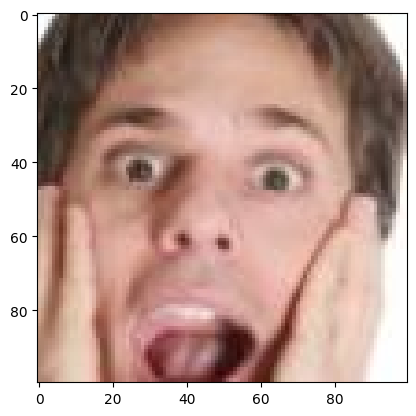

surprise
man
tensor([[ 2.1349, -2.3901]], device='cuda:0') tensor([[-1.8110, -0.9202, -1.6836, -1.3161,  4.8026,  2.4322, -1.2786]],
       device='cuda:0')


In [11]:

my_model=MTL_model.MultiTaskModel(phase='test')
state_dict=torch.load('weight/MTL/resnet18_only_FC_best.pt')
my_model.load_state_dict(state_dict)
my_model.to(device)
my_model.eval()

# test_ds=FERDataset('test')
# test_dl=DataLoader(test_ds,batch_size=32,shuffle=True,num_workers=1)
# corrects=0

# start=time.time()
# for img,label in test_dl:
#     img=img.to(device)
#     label=label.to(device)
#     output=my_model(img,task='')
#     emotion_output=output[1]
#     pred=emotion_output.argmax(1,keepdim=True)
    
#     corrects+=pred.eq(label.view_as(pred)).sum().item()
# end=time.time()
  
# accuracy=corrects/len(test_dl.dataset)
# print(f'test set accuracy: {accuracy*100:.2f}, inference time:{end-start}')


# test_ds=FERDataset('train')
# test_dl=DataLoader(test_ds,batch_size=32,shuffle=True,num_workers=1)
# corrects=0

# start=time.time()
# for img,label in test_dl:
#     img=img.to(device)
#     label=label.to(device)
#     output=my_model(img,task='')
#     emotion_output=output[1]
#     pred=emotion_output.argmax(1,keepdim=True)
    
#     corrects+=pred.eq(label.view_as(pred)).sum().item()
# end=time.time()
    
# accuracy=corrects/len(test_dl.dataset)
# print(f'train set accuracy: {accuracy*100:.2f}, inference time:{end-start}')
    
    
with torch.no_grad():

    img=cv2.imread('data/Expw-F/fear/86342excited_man_50.jpg')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    img=cv2.resize(img,(128,128))
    img=np.transpose(img,(2,0,1))
    img=torch.FloatTensor(img).to(device)
    img=torch.unsqueeze(img,0)/255.0
    

    output=my_model(img,task='')
    gender_output,emo_output=output
    
    gender_pred=gender_output.argmax(1,keepdim=True)
    emo_pred=emo_output.argmax(1,keepdim=True)
    
    print(labels[emo_pred.item()])
    print(gender[gender_pred.item()])
    print(gender_output,emo_output)
     
    